### Data Exploration

In [132]:
import transformers
from transformers import BertModel, BertTokenizer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

RANDOM_SEED = 42


In [70]:
# loading the reviews dataset
df = pd.read_csv('reviews.csv')
df.shape

(17660, 13)

In [71]:
# check missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17660 entries, 0 to 17659
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              17660 non-null  object
 1   userName              17660 non-null  object
 2   userImage             17660 non-null  object
 3   content               17659 non-null  object
 4   score                 17660 non-null  int64 
 5   thumbsUpCount         17660 non-null  int64 
 6   reviewCreatedVersion  15137 non-null  object
 7   at                    17660 non-null  object
 8   replyContent          9792 non-null   object
 9   repliedAt             9792 non-null   object
 10  appVersion            15137 non-null  object
 11  sortOrder             17660 non-null  object
 12  appId                 17660 non-null  object
dtypes: int64(2), object(11)
memory usage: 1.8+ MB


Text(0.5, 0, 'review score')

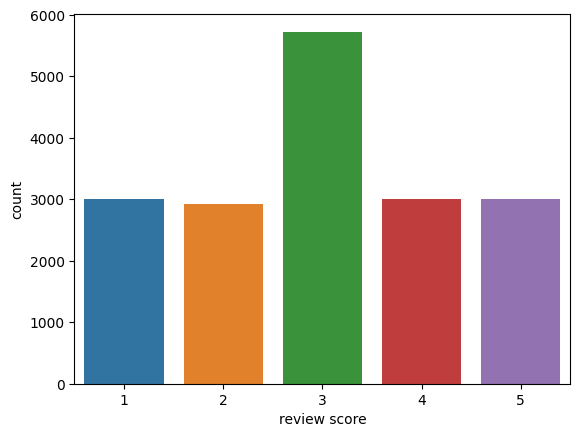

In [72]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
sns.countplot(x='score', data=df, hue='score', palette=colors, legend=False)
plt.xlabel('review score')

The dataset is imbalanced.

In [73]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

df['sentiment'] = df.score.apply(to_sentiment)

C:\Users\hp\AppData\Local\Temp\ipykernel_25152\1125166575.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_names)


[Text(0, 0, 'negative'), Text(1, 0, 'neutral'), Text(2, 0, 'positive')]

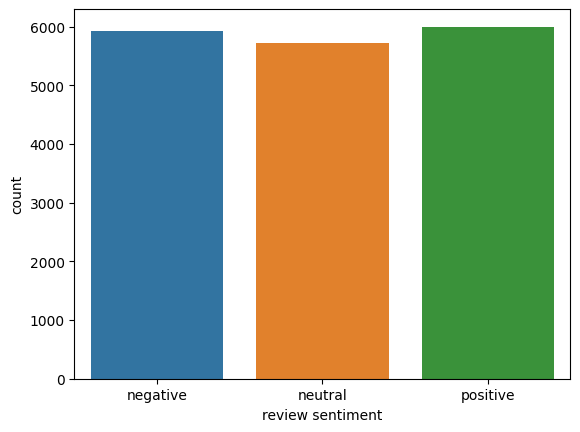

In [74]:
class_names = ['negative', 'neutral', 'positive']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
ax = sns.countplot(x='sentiment', data=df, hue='sentiment', palette=colors, legend=False)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

The balance is mostly restored

### Data Preprocessing

In [75]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [76]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [77]:
text = 'When was I last outside? I am stuck at home for 2 weeks.'
tokens = tokenizer.tokenize(text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

In [78]:
print(f'Sentence: {text}')
print(f'Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

Sentence: When was I last outside? I am stuck at home for 2 weeks.
Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


Special Tokens

In [79]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [80]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [81]:
encoding = tokenizer.encode_plus(
    text,
    max_length=32,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt'
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\hp\anaconda3\envs\torch\Lib\site-packages\transformers\tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [82]:
encoding

{'input_ids': tensor([[ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
         1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])}

In [83]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

- BertTokenized automatically handles the inclusion of special tokens like `[CLS]` and `[SEP]` when`add_special_tokens=True` parameter is set.

- **[CLS] Token**: The tokenized automatically adds the `[CLS]` token at the beginning of the input sequence. This token is used by BERT as a special token to represent the entire sequence for classification tasks.
- **[SEP] Token**: This token is added at the end of the input by the tokenizer. This token is used to separate different parts of the input or to mark the end of a single sequence.
- **[PAD] Token**: The `pad_to_max_length=True` parameter ensures that the input sequnce is padded to the maximum length specified by `max_length`
- **attention_mask**: A binary mask indicating which tokens are actual input tokens (1) and which are padding tokens (0).

In [84]:
# Inverse the tokenization
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

### Choosing Sequence Length

In [85]:
# Handling `NaN` values 
# Replace `NaN` with Empty String
df['content'] = df['content'].fillna('')

In [86]:
token_lengths = []
for text in df.content:
    tokens = tokenizer.encode(text, max_length=512)
    token_lengths.append(len(tokens))

Text(0.5, 9.444444444444438, 'Token count')

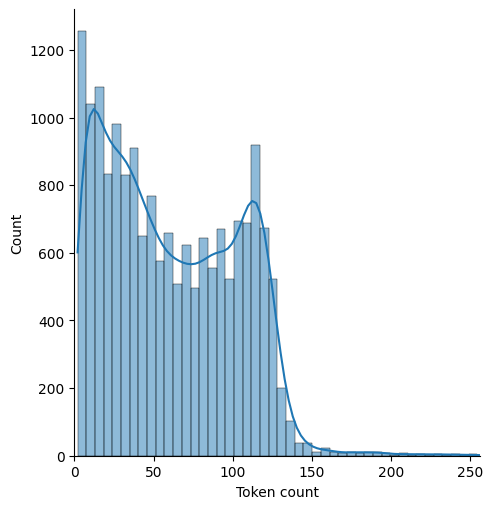

In [87]:
# plot the token_lengths distribution
sns.displot(token_lengths, kde=True)
plt.xlim([0, 256])
plt.xlabel('Token count')

Turns out most of the reviews seem to contain less than 200 tokens.

In [88]:
MAX_LEN = 200

In [89]:
df_train, df_test = train_test_split(
    df, test_size=0.1, random_state=RANDOM_SEED
)

In [90]:
df_val, df_test = train_test_split(
    df_test,
    test_size=0.5,
    random_state=RANDOM_SEED
)

In [91]:
df_train.shape, df_test.shape, df_val.shape

((15894, 14), (883, 14), (883, 14))

In [133]:
class GPReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }


In [137]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.content.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=MAX_LEN
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

In [138]:
BATCH_SIZE = 16

In [140]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [141]:
data = next(iter(train_data_loader))
data.keys()